所需数据集：scikit-learn 外置(需要下载、但只需下载一次)大数据集，政治家人脸图像数据集  
可以使用： sklearn.datasets.fetch_lfw_people 在首次使用之前 下载 该数据集。或者：  
将 lfwfunneled.tgz、pairs.txt、pairsDevTest.txt、pairDevTrain.txt 三个文件复制到 scikit-learn 数据文件夹($HOME/scikit_learn_data/lfw_home)中，并解压 tgz 文件夹到其下的 lfw_funneled 中（然后可以删除 .tgz文件）

## 0. 导入所需的包

In [1]:
# 导入所用到的包
from __future__ import print_function  
from time import time  
import logging  
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split  
from sklearn.datasets import fetch_lfw_people  
from sklearn.model_selection import GridSearchCV  
from sklearn.metrics import classification_report  
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score  
from sklearn.decomposition import PCA  
from sklearn.svm import SVC
import numpy as np

In [2]:
# 在控制台中显示/输出日志
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

## 1. 获取数据集

In [3]:
# 导入人脸数据集
# 下载数据集-政治家户外脸部数据集lfw（Labeled Faces in the Wild）
# 参数：
# minfaces_per_person:int,(原始样本数量：5760)可选,默认无，提取的数据集仅保留包含min_faces_per_person不同图片的人的照片
# resize调整每张人脸图片的比例(原始大小为h=62,w=47)，默认是0.5
# 提取中含有 70 张不同脸部图片的数据集，并重新修改大小为原来的 0.4 
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

## 2. 探查数据集

In [4]:
# 数据探查 - 满足上述条件的数据集
# 获取的图片形式的：样本(图片)个数、重置后的图片的长和宽  
n_samples, h, w = lfw_people.images.shape  
n_samples
(h, w)

1288

(50, 37)

In [5]:
# 获取数据集的用于机器学习的数据(矩阵/数组)形式的：行(样本数)，列(特征维度)
X = lfw_people.data  
# 获取数据集的的大小，行、列数，其中：
# 行数：就是样本、图片的个数 == 1288
# 列数：就是图片展平后的大小 == 50*37 就是用于机器学习的特征维度
row_num,col_num = X.shape
row_num, col_num
n_features = n_features = X.shape[1]  # n_features = col_num
n_features

(1288, 1850)

1850

In [6]:
# 获取数据集的标签，并输出
y = lfw_people.target  
y
# 输出 y 的类型
type(y)
# 获取 y 的所有元素的唯一取值（即不同的类别的信息），并输出
unique_values = np.unique(y)
unique_values
# 共有 7 个类别（人物），取值为：0~7

array([5, 6, 3, ..., 5, 3, 5], dtype=int64)

numpy.ndarray

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [7]:
# 获取每个类别的名称（人物的名称），并输出
target_names = lfw_people.target_names  
target_names
# 分别为：  阿里埃勒·沙龙、科林·鲍威尔、唐纳德·拉姆斯菲尔德、乔治·W·布什、格哈德·施罗德、乌戈·查韦斯、 托尼·布莱尔

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [8]:
# 获取类别的数量
# n_classes = target_names.shape
n_classes = target_names.shape[0]  
n_classes

7

In [9]:
# 打印输出
print("Total dataset size:")  
print("n_samples: %d" % n_samples)  
print("n_features: %d" % n_features)  
print("n_classes: %d" % n_classes) 

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


## 3. 拆分数据集

In [10]:
# 使用 train_test_split 拆分数据集，训练集-75%，测试集-25%，
# 随机数-暂时固定为42，以保证每次执行可复现数据划分, 后期可以删除此赋值，以便每次均为随机拆分
# 通过 stratify=y. 启用分层拆分
# 亦可 设置 shuffle 布尔值（默认True），用于确定在应用拆分之前是否对数据集进行混洗。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)  
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((966, 1850), (322, 1850), (966,), (322,))

## 4. 提取特征 - 特征降维

In [11]:
# 原始数据的特征向量维度非常高，意味着训练模型的复杂度非常高
# 采用PCA算法，完成特征降维
# 设置保存下的组件数目，也即保留下来的特征个数，即提取的主成分数量
n_components = 150  
n_components
X_train.shape

150

(966, 1850)

In [12]:
# 记下 PCA 降维操作之前的时间
begin_pca_time = time()  
# 建立无监督学习中 PCA 模型
# 降维使用的是随机降维
# 执行 PCA 降维，缩减为 n_components 个维度
# whiten是一种数据预处理方式，会损失一些数据信息，但可获得更好的预测结果
pca = PCA(svd_solver='randomized',n_components=n_components, whiten=True).fit(X_train)  
# 记下 PCA 降维的 fit 的时间，并输出 输出 PCA 降维 fit 操作所花费的时间
end_pca_fit_time = time()
end_pca_fit_time - begin_pca_time

0.3089320659637451

In [13]:
print("Projecting the input data on the eigenfaces orthonormal basis")  
# 得到特征脸(将原先的特征向量(h,w)重新排布为主成分数量(150)个) 
# n_comonents参数就是要降成的维度，PCA模型建立好之后就可以执行pac.transform进行数据降维了。
eigenfaces = pca.components_.reshape((n_components, h, w))  
type(eigenfaces)
eigenfaces.shape

Projecting the input data on the eigenfaces orthonormal basis


numpy.ndarray

(150, 50, 37)

In [14]:
# 开始执行pac.transform进行数据降维。
# 记下开始 transform 的时间
begin_pca_transform_time = time()  
# 对训练集进行 PCA 降维
X_train_pca = pca.transform(X_train)  
# 对测试集进行 PCA 降维
X_test_pca = pca.transform(X_test)  
# 记下结束 transform 的时间，并输出 transform 的时间
end_pca_transform_time = time()  
end_pca_transform_time - begin_pca_transform_time
# 输出降维后的 训练集和测试集 的 shape
X_train_pca.shape
X_test_pca.shape
# 均已降维到 150 个特征

0.012000799179077148

(966, 150)

(322, 150)

# 5. 建立模型

In [15]:
# 建立SVM分类模型
print("Fitting the classifier to the training set")  
# c是一个对错误的部分的惩罚
# gamma的参数对不同核函数有不同的表现，gamma表示使用多少比例的特征点
# 实际应用中，会使用不同的c和不同值的gamma，进行多个量的尝试，然后进行搜索，选出准确率最高模型
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],  
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }  
# GridSearchCV是寻找合适的SVM参数组合的,调用SVM进行分类搜索哪对组合产生最好的归类精确度
# kernel：rbf高斯径向基核函数
# class_weight：采用平衡权重,表示调整各类别权重，权重与该类中样本数成反比，
# 防止模型过于拟合某个样本数量过大的类
# 把所有上述所列参数的组合都放在SVC里面进行计算，最后看出哪一组函数的表现度最好
# rbf处理图像较好，穷举 C和gamma 组合，找出最好的一个组合
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid=param_grid)  

Fitting the classifier to the training set


## 6. 训练模型

In [16]:
# 记下开始训练的时间
begin_svm_fit_time = time()  
# 使用 svm 基于训练集进行训练
clf = clf.fit(X_train_pca, y_train)  
# 记下结束训练的时间，并输出
end_svm_fit_time = time()
end_svm_fit_time - begin_svm_fit_time
# 输出最好的组合，即：最好的模型的信息  
clf.best_estimator_

16.050432920455933

SVC(C=1000.0, class_weight='balanced', gamma=0.005)

In [17]:
print("Best estimator found by grid search:")  
print(clf.best_estimator_)  

Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


## 7. 评估模型

In [18]:
print("Predicting people's names on the test set")  
begin_svm_predict_time = time()
# 使用模型预测 测试集
y_pred = clf.predict(X_test_pca)  
end_svm_predict_time = time()
end_svm_predict_time - begin_svm_predict_time

Predicting people's names on the test set


0.09200000762939453

In [19]:
# 通过classification_report方法进行查看得到预测结果中的报告信息及概述信息。
# 显示了模型的精度、召回率、F1分数和支持分数
print(classification_report(y_test, y_pred, target_names=target_names))  
# 说明： 
# precision是预测的准确率，recall是召回率，
# f1-score是兼顾考虑了Precision和Recall的评估指标。
# 他们的数值越接近1说明预测的越准。

                   precision    recall  f1-score   support

     Ariel Sharon       0.92      0.58      0.71        19
     Colin Powell       0.84      0.88      0.86        59
  Donald Rumsfeld       0.91      0.33      0.49        30
    George W Bush       0.76      0.97      0.85       133
Gerhard Schroeder       0.69      0.41      0.51        27
      Hugo Chavez       0.67      0.33      0.44        18
       Tony Blair       0.71      0.83      0.77        36

         accuracy                           0.77       322
        macro avg       0.78      0.62      0.66       322
     weighted avg       0.78      0.77      0.75       322



In [20]:
# 混淆矩阵
# 一个n*n的方格，横行和纵行分别表示真实的每一组测试的标记和测试集标记的差别
# 对角线表示的是正确的值，对角线数字越多表示准确率越高
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
# 说明：
# 如果全部都是100%预测，那么数据应该都排列在对角线上，也就是说，每一个行列对应之后就会在对角线上+1，
# 第一行上有9个预测正确，另外有4(1+1+2)个预测失败，这个正确率比较低，不过剩下的几个就比较高了。

[[ 11   1   0   7   0   0   0]
 [  1  52   0   6   0   0   0]
 [  0   6  10  12   1   0   1]
 [  0   2   0 129   0   0   2]
 [  0   0   1   5  11   2   8]
 [  0   1   0   6   4   6   1]
 [  0   0   0   5   0   1  30]]


In [21]:
# 计算识别的精度，并输出
score = accuracy_score(y_test, y_pred)
score

0.7732919254658385

## 预测结果可视化

In [22]:
%matplotlib inline 

In [23]:
# 将测试标记过进行展示
# 创建通用的图片可视化函数：
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    #建立图作为背景
    #自定义画布大小
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))  
    #调整位置
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)  
    for i in range(n_row * n_col):  
        #设置画布划分以及图像在画布上输出的位置
        plt.subplot(n_row, n_col, i + 1)  
        #在轴上显示图片
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)  
        #输出画板的标题
        plt.title(titles[i], size=12)  
        #获取并设置x、y轴的当前刻度位置和标签
        plt.xticks(())  
        plt.yticks(())  
#打印预测函数类别标签和实际类别标签      
#返回预测人脸姓和测试人脸姓的对比title
def title(y_pred, y_test, target_names, i):  
    #rsplit（' ',1）从右边开始以右边第一个空格为界，分成两个字符
    #组成一个list
    #此处代表把'姓'和'名'分开，然后把后面的姓提出来
    #末尾加[-1]代表引用分割后的列表最后一个元素
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]  
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]  
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)  

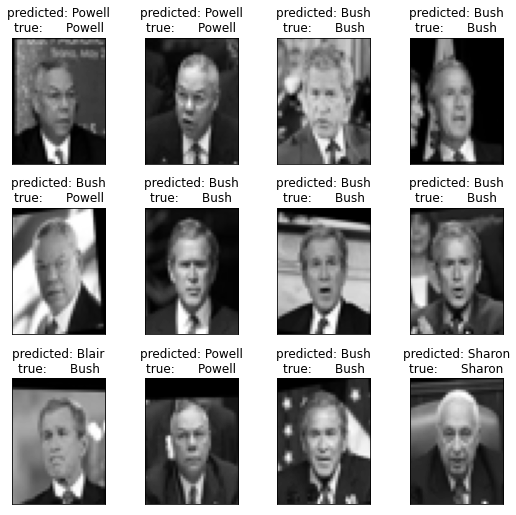

In [24]:
# 预测信息的可视化
#获取预测出的人名
prediction_titles = [title(y_pred, y_test, target_names, i)  
                     for i in range(y_pred.shape[0])]  
#测试集的特征向量矩阵和要预测的人名打印
#打印原图和预测的信息, 调用plot_gallery函数打印出实际是谁，预测的谁
plot_gallery(X_test, prediction_titles, h, w)  

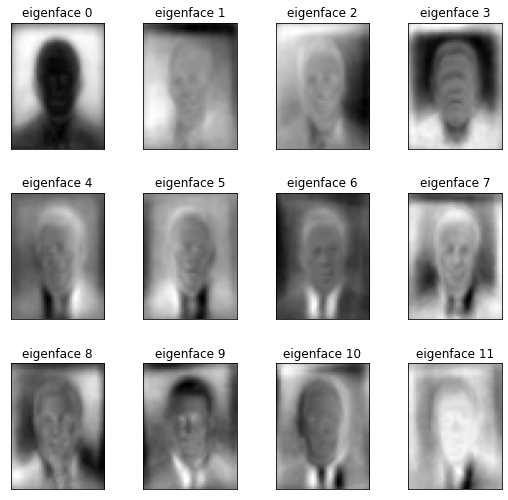

In [25]:
# 特征脸可视化
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])] 
#调用plot_gallery函数打印出提取过特征的脸
plot_gallery(eigenfaces, eigenface_titles, h, w)  

## 使用 AT&T ORL dataset

下载位置:   https://www.kaggle.com/datasets/kasikrit/att-database-of-faces  
解压到: orl_face_dataset 下, s1~s40 目录中  
安装 cv2 模块:  
    pip install opencv-python （如果只用主模块，使用这个命令安装）  
    pip install opencv-contrib-python （如果需要用主模块和contrib模块，使用这个命令安装），推荐安装这个。

In [26]:
import cv2
PICTURE_PATH = "orl_face_dataset"
def get_Image():
    for i in range(1,41):
        for j in range(1,11):
            path = PICTURE_PATH + "\\s" + str(i) + "\\"+ str(j) + ".pgm"
            img = cv2.imread(path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            h,w = img_gray.shape
            img_col = img_gray.reshape(h*w)
            all_data_set.append(img_col)
            all_data_label.append(i)
    return h,w

In [27]:
all_data_set = []
all_data_label = []
h,w = get_Image()
 
X = np.array(all_data_set)  
y = np.array(all_data_label)
n_samples,n_features = X.shape
n_classes = len(np.unique(y))
target_names = []
for i in range(1,41):
    names = "person" + str(i)
    target_names.append(names)
 
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 400
n_features: 10304
n_classes: 40


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [29]:
n_components = 150
print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
 
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 300 faces
done in 1.824s


In [30]:
eigenfaces = pca.components_.reshape((n_components, h, w))  
 
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)   
X_test_pca = pca.transform(X_test)     
print("done in %0.3fs" % (time() - t0))
X_train_pca.shape
y_train.shape
X_test_pca.shape
y_train.shape

Projecting the input data on the eigenfaces orthonormal basis
done in 0.109s


(300, 150)

(300,)

(100, 150)

(300,)

In [31]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 3.981s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)


In [32]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))
y_pred

Predicting people's names on the test set
done in 0.019s


array([25,  6, 16, 31, 38,  1, 37,  5, 34, 18, 15, 39, 18, 28, 40, 21,  3,
        8,  1, 37, 24, 13,  2, 22, 21, 36, 39, 27, 30,  6,  8, 17,  8, 36,
       23,  9,  2, 15, 20, 12, 29, 33, 40, 30, 23, 33, 30, 35, 14, 26,  5,
       24, 34,  9, 29, 11,  8,  4, 20, 40, 13,  7,  1, 22, 32,  2, 12, 23,
        4, 27, 10, 19, 28,  3, 14, 19,  5, 12, 31, 13, 30,  7, 25, 11, 26,
       17, 39, 21, 24, 23, 38, 36, 15, 37,  3, 11, 10, 31, 29,  6])

In [33]:
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

              precision    recall  f1-score   support

     person1       0.67      1.00      0.80         2
     person2       1.00      1.00      1.00         3
     person3       1.00      1.00      1.00         3
     person4       1.00      0.67      0.80         3
     person5       0.67      1.00      0.80         2
     person6       1.00      1.00      1.00         3
     person7       1.00      1.00      1.00         2
     person8       0.75      1.00      0.86         3
     person9       1.00      1.00      1.00         2
    person10       1.00      1.00      1.00         2
    person11       1.00      1.00      1.00         3
    person12       1.00      1.00      1.00         3
    person13       0.67      1.00      0.80         2
    person14       1.00      1.00      1.00         2
    person15       1.00      1.00      1.00         3
    person16       1.00      0.50      0.67         2
    person17       1.00      1.00      1.00         2
    person18       1.00    

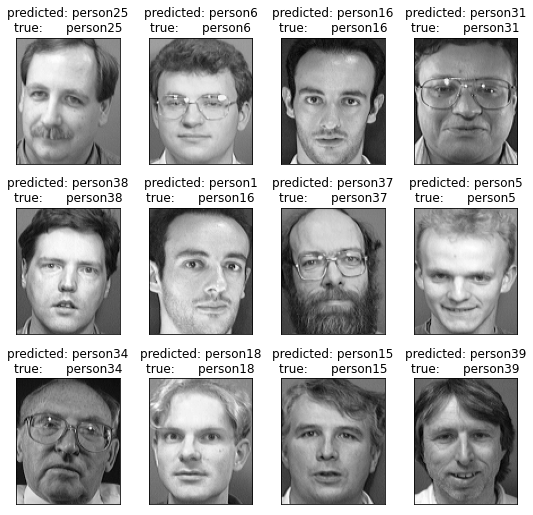

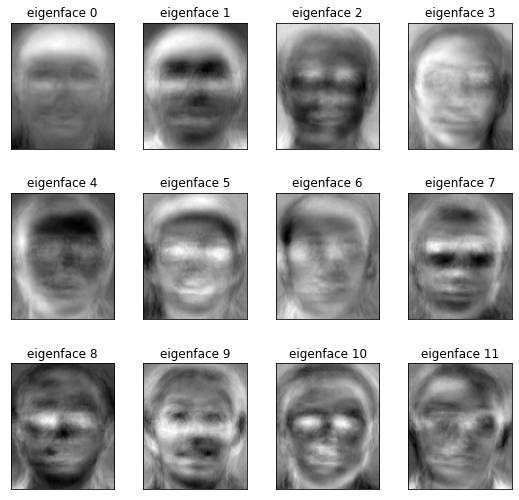

In [34]:
def orl_plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
 
 

def orl_title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]-1]
    true_name = target_names[y_test[i]-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)
 
prediction_titles = [orl_title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
orl_plot_gallery(X_test, prediction_titles, h, w)
 

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
orl_plot_gallery(eigenfaces, eigenface_titles, h, w)
 
plt.show()

# 以上!